# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.


## Preparación

In [1]:
# importar librerias 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

# statsmodels para series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Métricas
from sklearn.metrics import mean_squared_error

# División de datos
from sklearn.model_selection import train_test_split

# Modelos de regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Modelos avanzados
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor



In [2]:
# cargar DataFrame 
# index_col=[0]: Usa la primera columna (columna 0) como índice del DataFrame.
# parse_dates=[0]: Convierte esa primera columna en formato de fecha (datetime).
data = pd.read_csv("https://raw.githubusercontent.com/Bortone-lab/TAXI/refs/heads/main/taxi.csv", index_col=[0], parse_dates = [0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
# Ver info 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.shape

(26496, 1)

In [5]:
# saber si hay datos NaN
data.isnull().mean()

num_orders    0.0
dtype: float64

In [6]:
# Agrupa los datos por intervalos de 1 hora.
data = data.resample("1h").sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Análisis

<Axes: title={'center': 'Número de pedidos por dayofweek'}, xlabel='dayofweek', ylabel='Pedidos'>

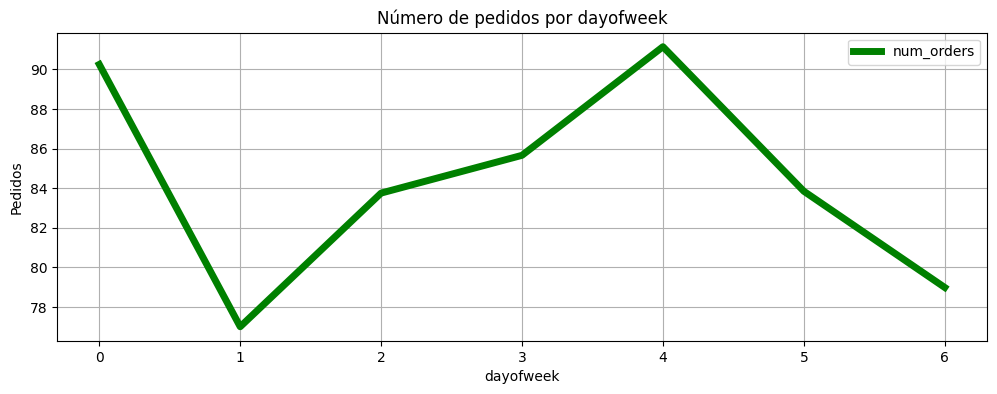

In [7]:
# datos agrupados por dayofweek 
data.groupby(data.index.dayofweek).mean().plot(
    y='num_orders',
    figsize=(12, 4),
    color='green',
    linewidth=5,
    grid=True,
    title='Número de pedidos por dayofweek',
    xlabel='dayofweek',
    ylabel='Pedidos'
)

<Axes: title={'center': 'Número de pedidos por month'}, xlabel='month', ylabel='Pedidos'>

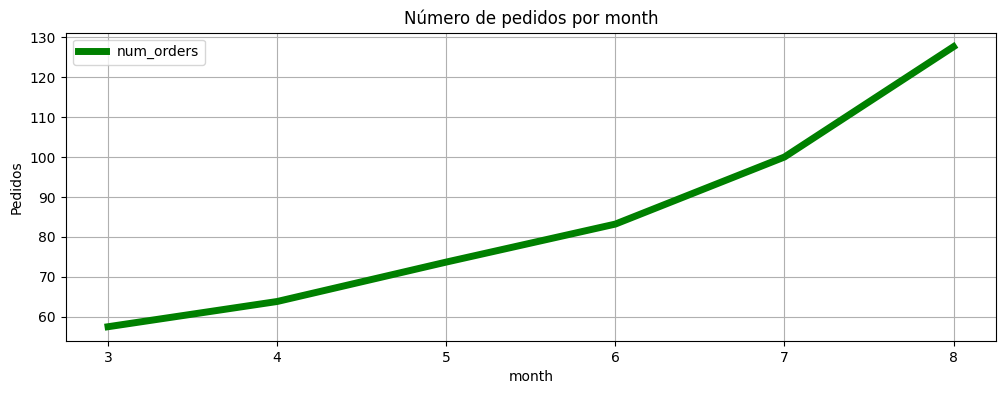

In [8]:
# datos agrupados por month 
data.groupby(data.index.month).mean().plot(
    y='num_orders',
    figsize=(12, 4),
    color='green',
    linewidth=5,
    grid=True,
    title='Número de pedidos por month',
    xlabel='month',
    ylabel='Pedidos'
)

<Axes: title={'center': 'Número de pedidos por hora'}, xlabel='Hora', ylabel='Pedidos'>

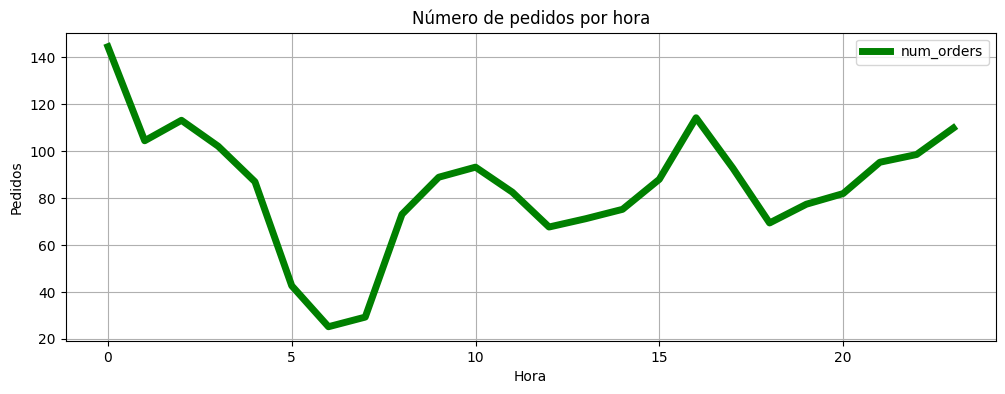

In [9]:
# datos agrupados por hora 
data.groupby(data.index.hour).mean().plot(
    y='num_orders',
    figsize=(12, 4),
    color='green',
    linewidth=5,
    grid=True,
    title='Número de pedidos por hora',
    xlabel='Hora',
    ylabel='Pedidos'
)

El gráfico nos dice que hay más pedidos en la tarde, sobre las 15 PM, llegando hasta 140. Por la mañana 5 AM y noche 8 PM hay muy pocos. Podemos ver cuándo necesitamos más personal o recursos para cubrir la demanda alta.

<Axes: xlabel='datetime'>

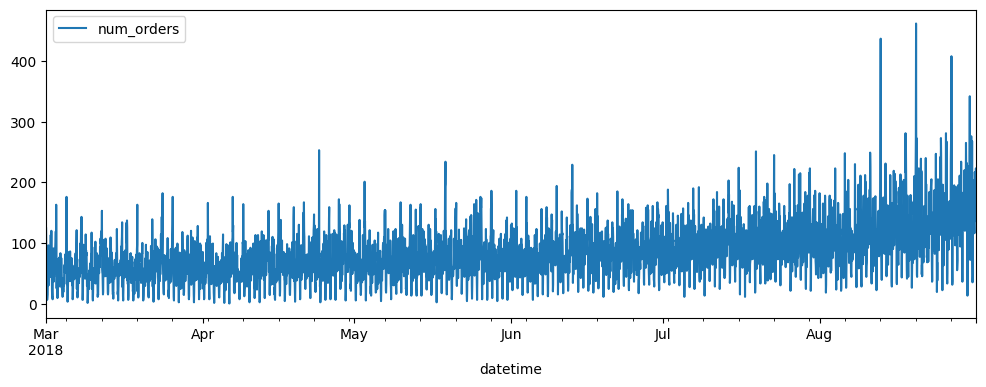

In [10]:
data.plot(figsize=[12,4])

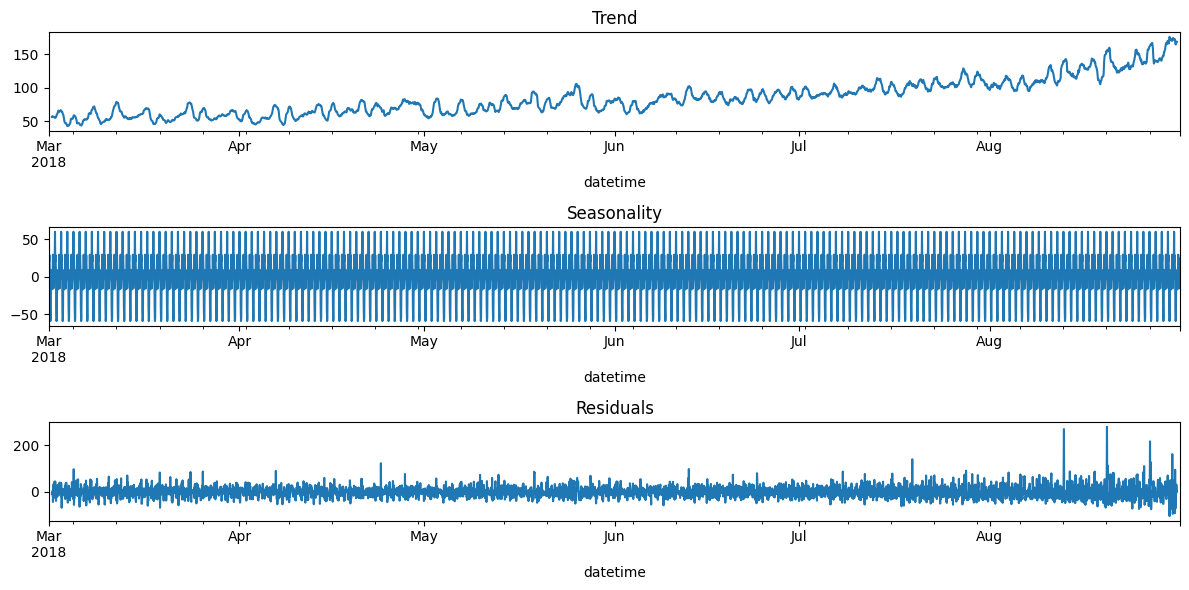

In [11]:
# Descomponemos la serie temporal en tendencia, estacionalidad y residuo
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 6))

#  tendencia
plt.subplot(311)  # fila 1, columna 1
decomposed.trend.plot(ax=plt.gca())  #  tendencia en el eje actual
plt.title('Trend')  

#  estacionalidad
plt.subplot(312)  # fila 2, columna 1
decomposed.seasonal.plot(ax=plt.gca())  
plt.title('Seasonality') 

#  residuos (ruido)
plt.subplot(313)  # fila 3, columna 1
decomposed.resid.plot(ax=plt.gca())  
plt.title('Residuals') 

plt.tight_layout()


Tendencia: Hay un crecimiento constante del valor a lo largo del tiempo.

Estacionalidad: Se observa un patrón cíclico regular que se repite con frecuencia.

Residuos: Los datos restantes tienen variabilidad, pero sin una estructura clara.

In [12]:
# estadisticas 
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<Axes: xlabel='datetime'>

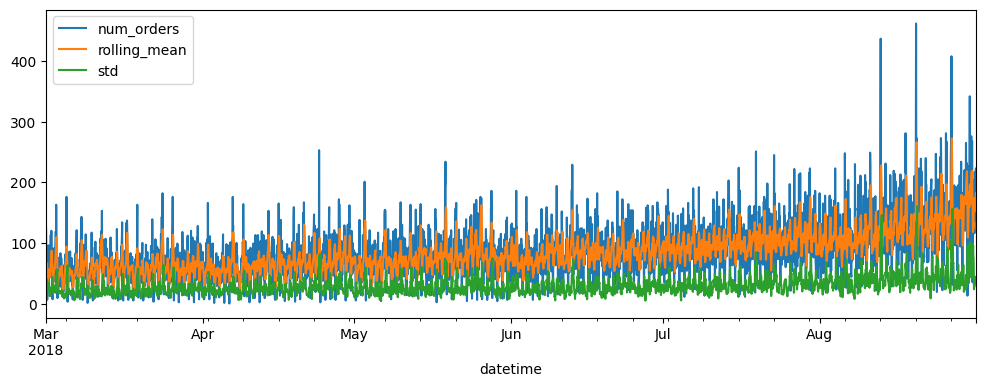

In [13]:
# grafica para comparar rolling_mean
data_1 = data.copy()
data_1["rolling_mean"] = data.rolling(6).mean()
data_1['std'] = data_1["num_orders"].rolling(6).std()
data_1.plot( figsize = [12,4])

<Axes: xlabel='datetime'>

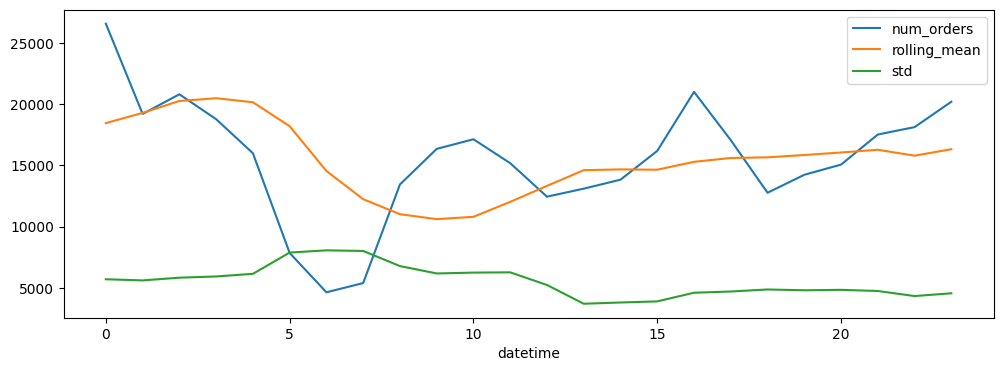

In [14]:
data_1.groupby(data_1.index.hour).sum().plot(figsize = [12,4] )

 - La std aproximadamenta es de 5000 lo cual es baja 
 - La media movil se compensa en  una ligera tendencia a la alta y suaviza los datos.

<Axes: ylabel='Frequency'>

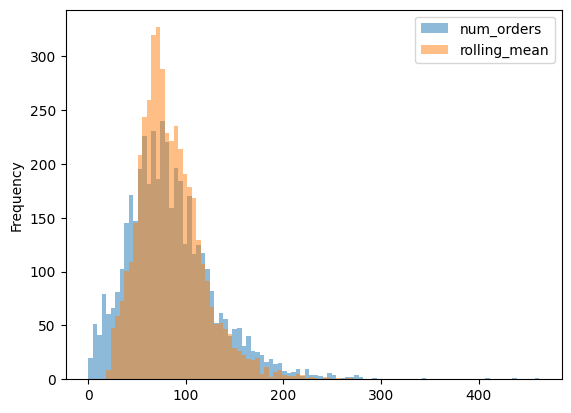

In [15]:
# Histograma de la variable original num_orders y la media movil rolling_mean 
data_1[["num_orders","rolling_mean"]].plot(kind = "hist", bins = 100, alpha= 0.5)

Esto sugiere que, aunque los pedidos diarios pueden ser volátiles, el comportamiento general muestra cierta estabilidad y crecimiento moderado

## Outliers 

<Axes: >

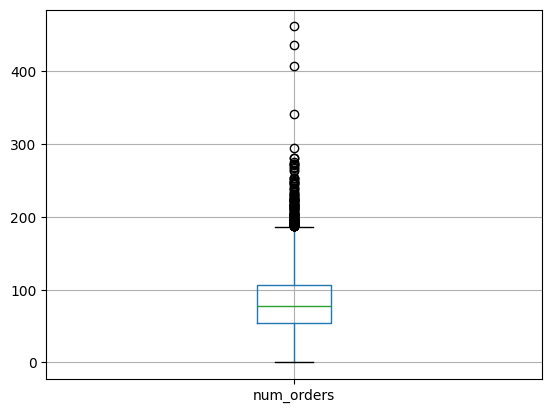

In [16]:
data.boxplot()

In [17]:
# Calcular percentiles solo para la columna 'num_orders'
q1 = data["num_orders"].quantile(0.25)
q3 = data["num_orders"].quantile(0.75)
iqr = q3 - q1

# Mostrar resultados con formato
print(f"Q1 (25%): {q1:.2f}")
print(f"Q3 (75%): {q3:.2f}")
print(f"IQR (Q3 - Q1): {iqr:.2f}")


Q1 (25%): 54.00
Q3 (75%): 107.00
IQR (Q3 - Q1): 53.00


In [18]:
# limite superior
upper_limit = q3 + 1.5 * iqr
# limite inferior
lower_limit = q1 - 1.5 * iqr

print("Superior:", upper_limit)
print("Inferior:", lower_limit)

Superior: 186.5
Inferior: -25.5


In [19]:
# Eliminar outliers
data = data[data["num_orders"] < upper_limit]


<Axes: >

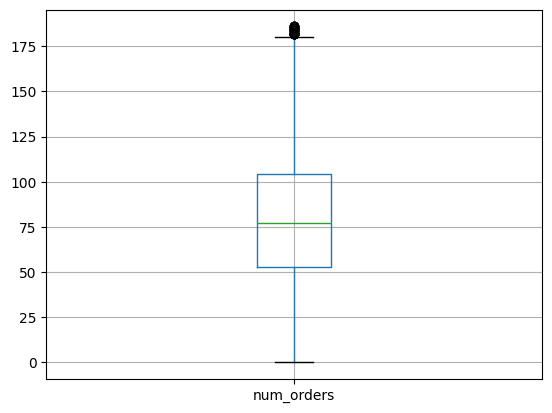

In [20]:
data.boxplot()

## Crear features 

In [21]:
# crear caracteristicas 
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data["hour"] = data.index.hour
    data["day"] = data.index.day
    data["dayofweew"] = data.index.dayofweek
    data["month"] = data.index.month
   

    for lag in range(1, max_lag+1):
        data["lag_{}".format(lag)] = data["num_orders"].shift(lag)
        
    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling_mean_size).mean()
     
    return data


In [22]:
# Crear features  
data = make_features(data,4, 6)
# Eliminar NaN
data = data.dropna()
data

,num_orders,hour,day,dayofweew,month,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 06:00:00,12,6,1,3,3,6.0,43.0,66.0,71.0,65.833333
2018-03-01 07:00:00,15,7,1,3,3,12.0,6.0,43.0,66.0,47.166667
2018-03-01 08:00:00,34,8,1,3,3,15.0,12.0,6.0,43.0,35.500000
2018-03-01 09:00:00,69,9,1,3,3,34.0,15.0,12.0,6.0,29.333333
2018-03-01 10:00:00,64,10,1,3,3,69.0,34.0,15.0,12.0,29.833333
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 14:00:00,133,14,31,4,8,166.0,136.0,167.0,182.0,122.000000
2018-08-31 15:00:00,116,15,31,4,8,133.0,166.0,136.0,167.0,138.333333
2018-08-31 19:00:00,136,19,31,4,8,116.0,133.0,166.0,136.0,150.000000


## Formación

In [23]:
# dividir los datos 
train, test = train_test_split(data, shuffle = False, test_size=0.1)

features_train = train.drop("num_orders",axis=1)
target_train = train["num_orders"]

features_test = test.drop("num_orders",axis=1)
target_test = test["num_orders"]

In [24]:
print("Valores NaN en features_train:")
print(features_train.isnull().sum())


Valores NaN en features_train:
hour            0
day             0
dayofweew       0
month           0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
rolling_mean    0
dtype: int64


## Modelos 

In [25]:
# Funcion de graficas 
def graf_a(predict):
    plt.figure(figsize=(14, 6))


    plt.plot(target_test.index, target_test.values, label="Valores reales", color="grey", linewidth=2, alpha=0.7)
    plt.plot(target_test.index, predict, label="Predicciones", color="teal", linestyle="-", linewidth=2, alpha=1)

    # Formato de fechas: mostrar más ticks
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mostrar cada día
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

    # Personalización
    plt.title("Predicción vs. Real a lo largo del tiempo", fontsize=14)
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Número de pedidos", fontsize=12)
    plt.legend(loc="upper left", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [26]:
# Funcion para las metricas 


### LinealRegression

In [27]:
# model LinealRegression 
model_regre = LinearRegression()
model_regre.fit(features_train, target_train)
predict_regre = model_regre.predict(features_test)



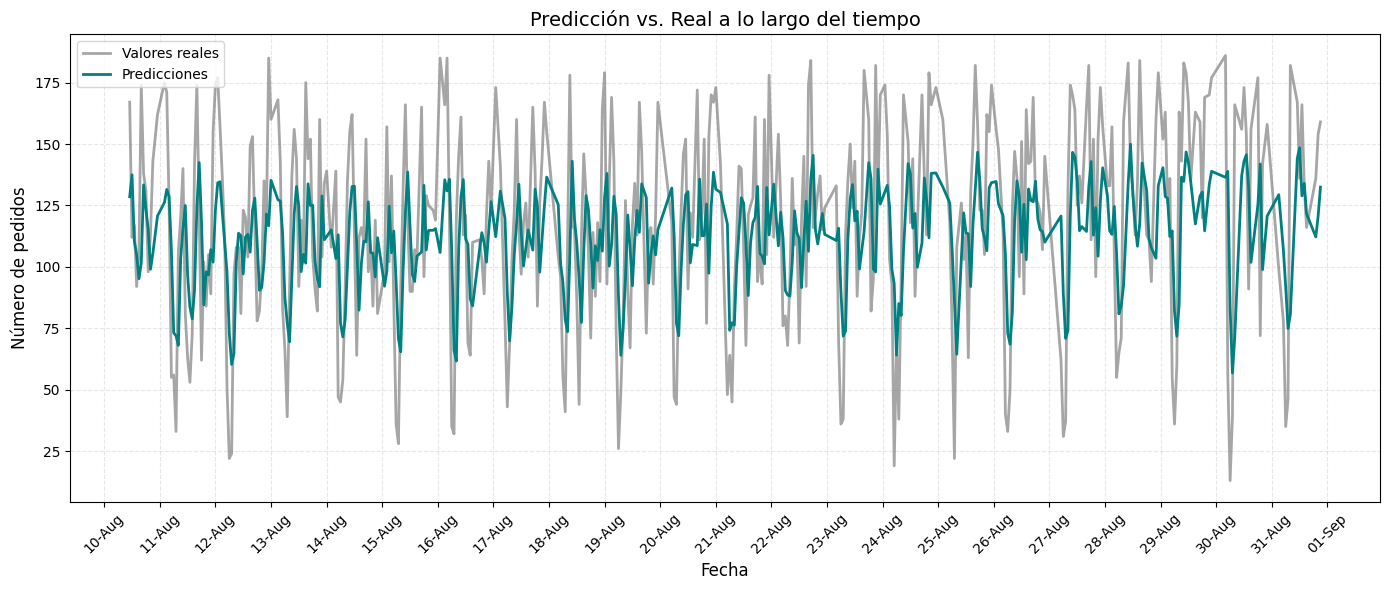

In [28]:
graf_a(predict_regre)

### RandonForestRegressor

In [29]:
# model RandonForestRegressor
model_forest = RandomForestRegressor(n_estimators=200, max_depth=10)
model_forest.fit(features_train,target_train)
predict_forest = model_forest.predict(features_test)
predict_forest.shape

(429,)

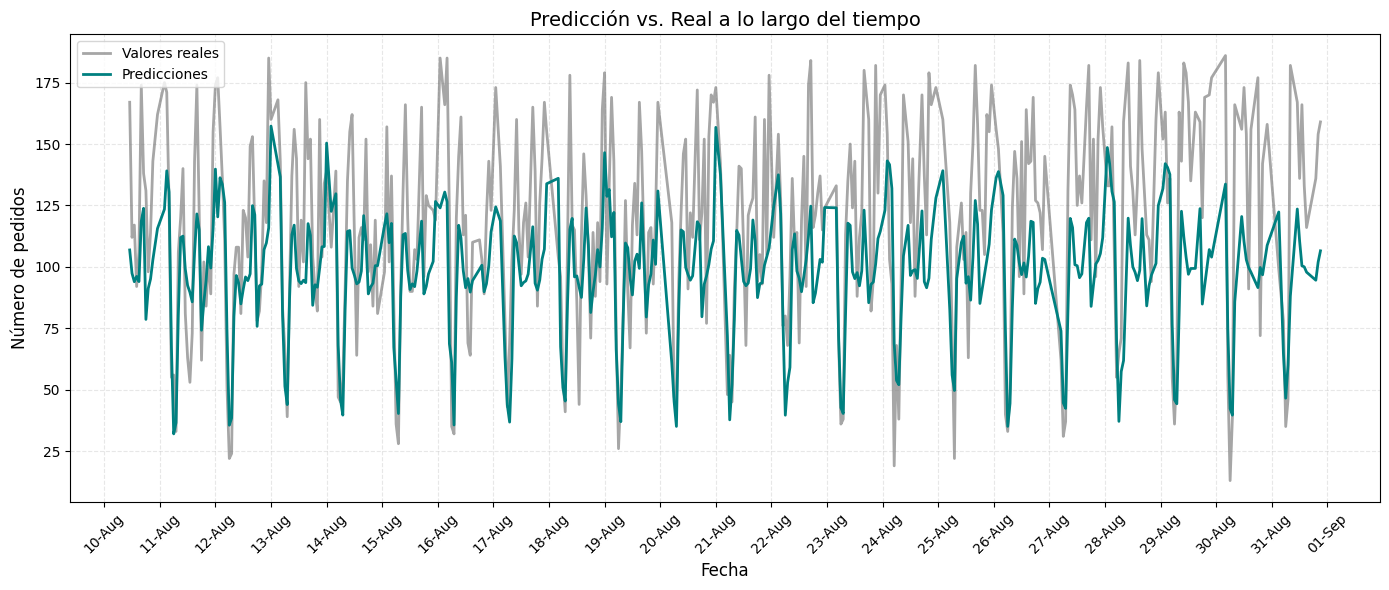

In [30]:
graf_a(predict_forest)

### XGBRegressor

In [31]:
# model XGBRegressor
model_xg = XGBRegressor()
model_xg.fit(features_train,target_train)
predict_xg = model_xg.predict(features_test)
predict_xg.shape

(429,)

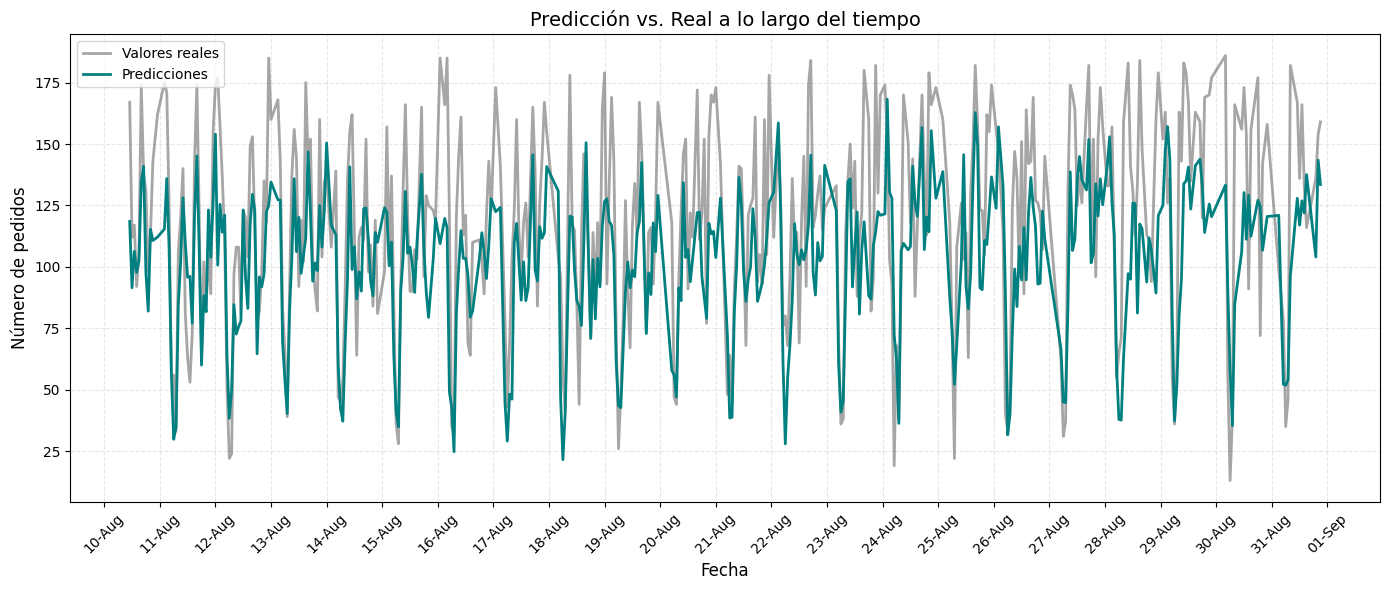

In [32]:
graf_a(predict_xg)

 ### LGMRegressor

In [33]:
# model LGMRegressor
model_lig = LGBMRegressor(n_estimators=300, max_depth=10, learning_rate=0.05, verbose=-1 )
model_lig.fit(features_train,target_train)
predict_lig = model_lig.predict(features_test)
predict_lig.shape

(429,)

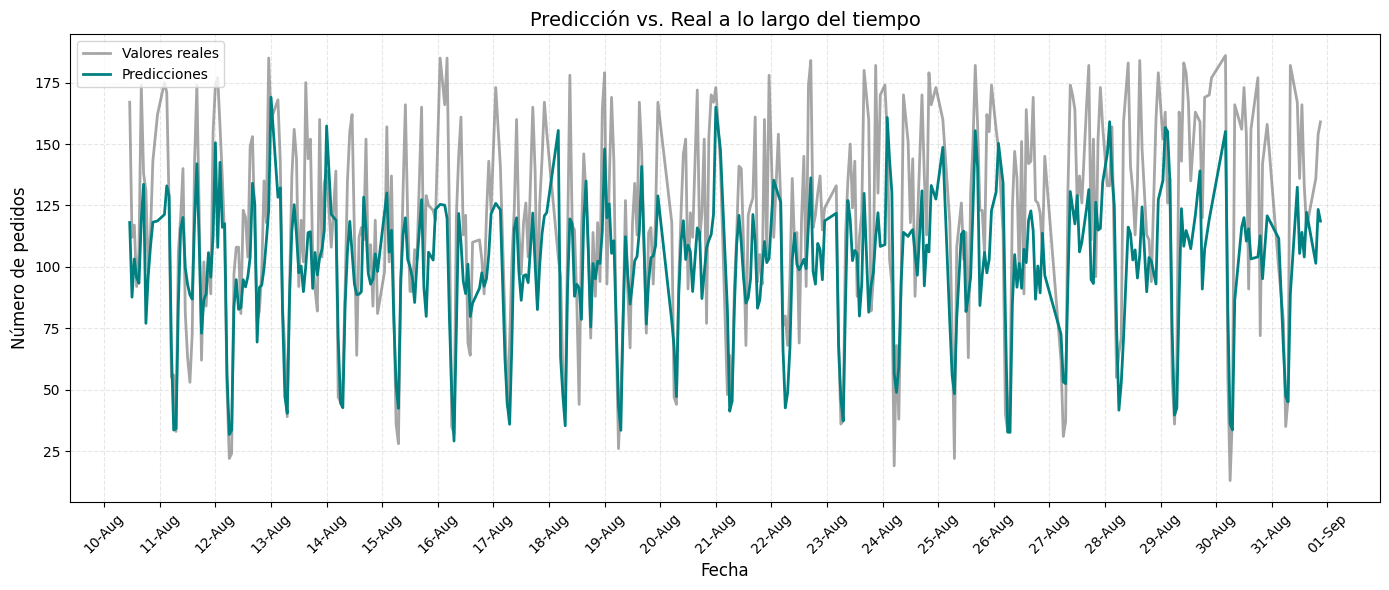

In [34]:
graf_a(predict_lig)

## Prueba

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

In [35]:
# funcion de recm
def recm(predict):
    recm = mean_squared_error(predict,target_test)**0.5
    return recm

In [36]:
print(f"LinearRegression: {recm(predict_regre):.2f}")
print(f"RandomForestRegressor: {recm(predict_forest):.2f}")
print(f"XGBRegressor: {recm(predict_xg):.2f}")
print(f"LGBMRegressor: {recm(predict_lig):.2f}")


LinearRegression: 35.35
RandomForestRegressor: 34.66
XGBRegressor: 31.87
LGBMRegressor: 31.98


En el análisis de los modelos de regresión, el XGBRegressor destaca como el más preciso con un RMSE de 31.87, seguido de cerca por el LGBMRegressor con 31.98, ambos superando al RandomForestRegressor 34.73 y al LinearRegression 35.35.